In [1]:
!pip install medmnist
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torchinfo import summary
import time
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
import pickle
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from medmnist import OCTMNIST
import torchinfo
from sklearn.preprocessing import label_binarize

In [3]:
data_train = OCTMNIST(split='train', download=True)
data_val = OCTMNIST(split='val', download=True)
data_test = OCTMNIST(split='test', download=True)
images = np.concatenate((data_train.imgs, data_val.imgs, data_test.imgs))
labels = np.concatenate((data_train.labels, data_val.labels, data_test.labels))


print("Full dataset shape:", images.shape)
print("Full labels shape:", labels.shape)


100%|██████████| 54.9M/54.9M [00:03<00:00, 14.9MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Full dataset shape: (109309, 28, 28)
Full labels shape: (109309, 1)


In [4]:
image_mean = np.mean(images)
image_std = np.std(images)
image_min = np.min(images)
image_max = np.max(images)

label_counts = np.bincount(labels.flatten().astype(int))

print(f"Mean pixel value: {image_mean}")
print(f"Standard deviation of pixel values: {image_std}")
print(f"Minimum pixel value: {image_min}")
print(f"Maximum pixel value: {image_max}")

print("\nLabel distribution:")
for i, count in enumerate(label_counts):
  print(f"Label {i}: {count} samples")


Mean pixel value: 48.20017843770356
Standard deviation of pixel values: 50.0743570420207
Minimum pixel value: 0
Maximum pixel value: 255

Label distribution:
Label 0: 37455 samples
Label 1: 11598 samples
Label 2: 8866 samples
Label 3: 51390 samples


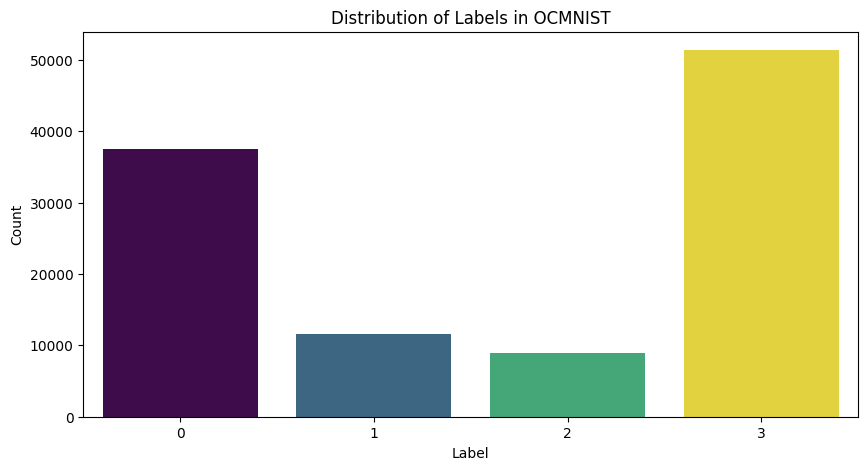

In [5]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(len(label_counts))), y=label_counts, hue=list(range(len(label_counts))), palette="viridis", legend=False)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in OCMNIST")
plt.show()

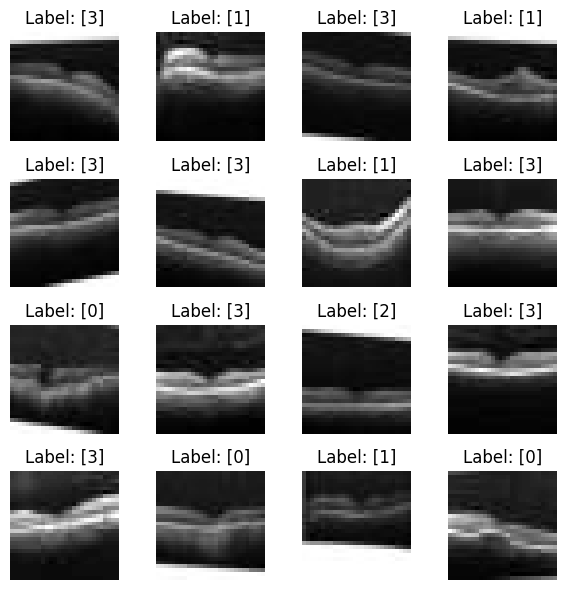

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, axises in enumerate(axes.flat):
    index = np.random.randint(0, len(images))
    axises.imshow(images[index], cmap='gray')
    axises.set_title(f"Label: {labels[index]}")
    axises.axis('off')
plt.tight_layout()
plt.show()

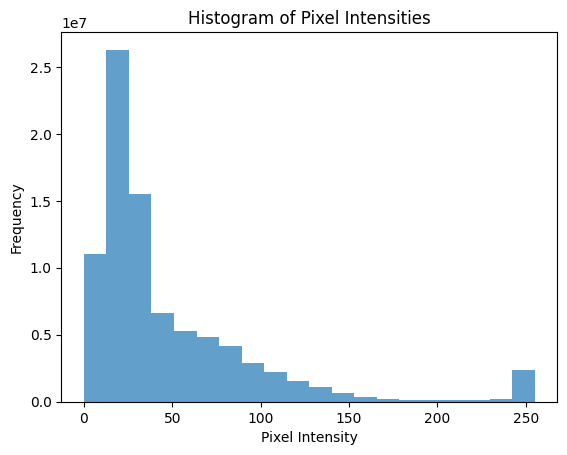

In [7]:
pixel_values = images.flatten()
plt.hist(pixel_values, bins=20, alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Pixel Intensities")
plt.show()

In [8]:
images = images.astype(np.float32) / 255.0
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)
labels_flat = labels.flatten()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_flat), y=labels_flat)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(labels_flat), class_weights)}
print("Class Weights:", class_weights_dict)
encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = encoder.fit_transform(labels_flat.reshape(-1, 1))
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)


Class Distribution: {0: 37455, 1: 11598, 2: 8866, 3: 51390}
Class Weights: {0: 0.7296021892938193, 1: 2.3562036558027244, 2: 3.0822524249943606, 3: 0.5317620159564117}
Training set: (76516, 28, 28) (76516, 4)
Validation set: (16396, 28, 28) (16396, 4)
Testing set: (16397, 28, 28) (16397, 4)


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = CNN()
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Linear: 1-5                            [1, 128]                  401,536
├─Dropout: 1-6                           [1, 128]                  --
├─Linear: 1-7                            [1, 64]                   8,256
├─Dropout: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 4]                    260
Total params: 428,868
Trainable params: 428,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.72
Estimated Total 

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
X_train_tensor = torch.tensor(X_train).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.argmax(axis=1))
X_val_tensor = torch.tensor(X_val).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.argmax(axis=1))
X_test_tensor = torch.tensor(X_test).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.argmax(axis=1))
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_base = running_loss / len(train_loader)
    train_accuracy_base = 100 * correct_train / total_train
    train_losses.append(train_loss_base)
    train_accuracies.append(train_accuracy_base)

    # Validation phase
    model.eval()
    val_loss_base = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss_base += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss_base /= len(val_loader)
    val_accuracy_base = 100 * correct_val / total_val
    val_losses.append(val_loss_base)
    val_accuracies.append(val_accuracy_base)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_base:.4f}, Train Acc: {train_accuracy_base:.2f}%, "
          f"Val Loss: {val_loss_base:.4f}, Val Acc: {val_accuracy_base:.2f}%")

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

Epoch [1/5], Train Loss: 0.8430, Train Acc: 68.38%, Val Loss: 0.7041, Val Acc: 75.04%
Epoch [2/5], Train Loss: 0.5991, Train Acc: 79.74%, Val Loss: 0.4910, Val Acc: 83.24%
Epoch [3/5], Train Loss: 0.5194, Train Acc: 82.66%, Val Loss: 0.4431, Val Acc: 84.75%
Epoch [4/5], Train Loss: 0.4828, Train Acc: 83.94%, Val Loss: 0.4231, Val Acc: 85.03%
Epoch [5/5], Train Loss: 0.4576, Train Acc: 84.69%, Val Loss: 0.4219, Val Acc: 84.91%
Training completed in 674.57 seconds.


In [13]:
# Test phase
model.eval()
test_loss_base = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss_base += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

test_loss_base /= len(test_loader)
test_accuracy_base = 100 * correct_test / total_test
print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.2f}%")


Test Loss: 0.4365, Test Accuracy: 84.71%


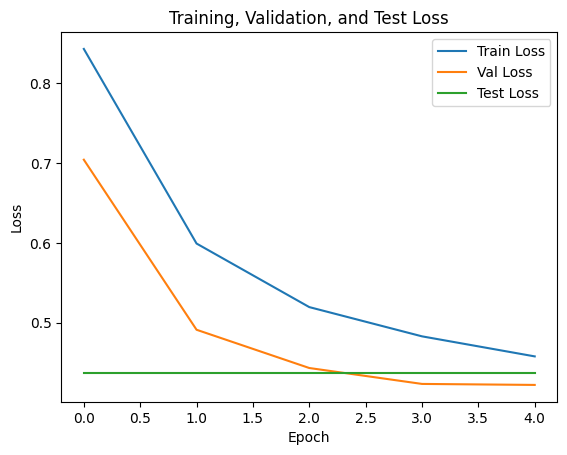

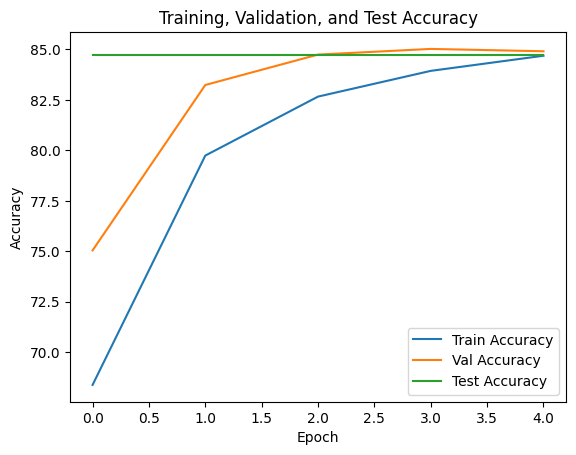

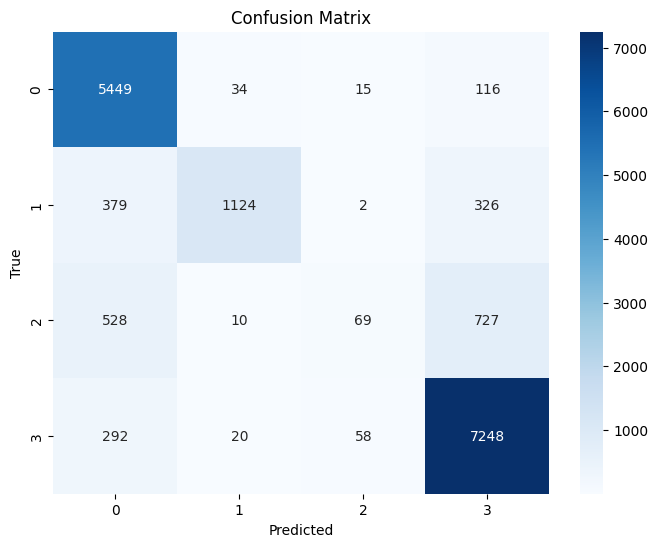

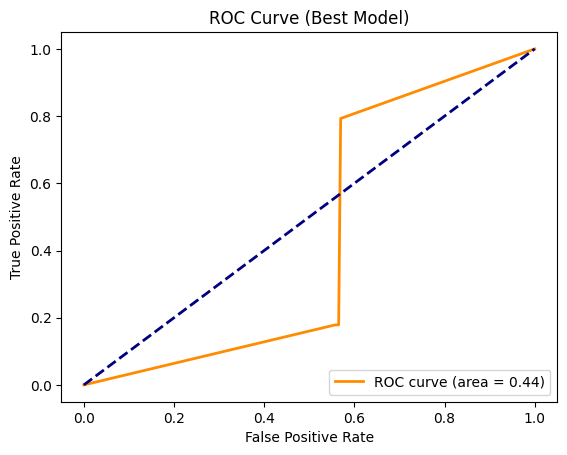

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot([test_loss_base] * num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot([test_accuracy_base] * num_epochs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

conf_matrix_best = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
roc_auc_best = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend(loc="lower right")
plt.show()

In [15]:
#MSE Loss
mse_loss = nn.MSELoss()
y_train_tensor_mse = torch.tensor(y_train).float()
y_val_tensor_mse = torch.tensor(y_val).float()
y_test_tensor_mse = torch.tensor(y_test).float()
train_dataset_mse = TensorDataset(X_train_tensor, y_train_tensor_mse)
val_dataset_mse = TensorDataset(X_val_tensor, y_val_tensor_mse)
test_dataset_mse = TensorDataset(X_test_tensor, y_test_tensor_mse)
train_loader_mse = DataLoader(train_dataset_mse, batch_size=batch_size, shuffle=True)
val_loader_mse = DataLoader(val_dataset_mse, batch_size=batch_size, shuffle=False)
test_loader_mse = DataLoader(test_dataset_mse, batch_size=batch_size, shuffle=False)

In [16]:
# Train with MSE Loss
model_mse = CNN()
optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)
train_losses_mse, val_losses_mse = [], []
train_accuracies_mse, val_accuracies_mse = [], []
start_time_mse = time.time()
for epoch in range(num_epochs):
    # Training phase
    model_mse.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader_mse:
        outputs = model_mse(inputs)
        loss = mse_loss(outputs, labels)

        optimizer_mse.zero_grad()
        loss.backward()
        optimizer_mse.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, true_labels = torch.max(labels.data, 1)
        total_train += true_labels.size(0)
        correct_train += (predicted == true_labels).sum().item()

    train_loss = running_loss / len(train_loader_mse)
    train_accuracy = 100 * correct_train / total_train
    train_losses_mse.append(train_loss)
    train_accuracies_mse.append(train_accuracy)

    # Validation phase
    model_mse.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader_mse:
            val_outputs = model_mse(val_inputs)
            val_loss += mse_loss(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            _, true_labels = torch.max(val_labels.data, 1)
            total_val += true_labels.size(0)
            correct_val += (predicted == true_labels).sum().item()

    val_loss /= len(val_loader_mse)
    val_accuracy = 100 * correct_val / total_val
    val_losses_mse.append(val_loss)
    val_accuracies_mse.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

training_time_mse = time.time() - start_time_mse
print(f"Training with MSE Loss completed in {training_time_mse:.2f} seconds.")

Epoch [1/5], Train Loss: 0.1158, Train Acc: 68.64%, Val Loss: 0.0915, Val Acc: 74.75%
Epoch [2/5], Train Loss: 0.0909, Train Acc: 76.34%, Val Loss: 0.0793, Val Acc: 78.26%
Epoch [3/5], Train Loss: 0.0813, Train Acc: 79.41%, Val Loss: 0.0685, Val Acc: 81.72%
Epoch [4/5], Train Loss: 0.0761, Train Acc: 80.93%, Val Loss: 0.0653, Val Acc: 82.78%
Epoch [5/5], Train Loss: 0.0721, Train Acc: 82.18%, Val Loss: 0.0645, Val Acc: 82.97%
Training with MSE Loss completed in 650.00 seconds.


In [17]:
# Test phase for MSE Loss model
model_mse.eval()
test_loss_mse = 0.0
correct_test_mse = 0
total_test_mse = 0
all_preds_mse = []
all_labels_mse = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader_mse:
        test_outputs = model_mse(test_inputs)
        test_loss_mse += mse_loss(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        _, true_labels = torch.max(test_labels.data, 1)
        total_test_mse += true_labels.size(0)
        correct_test_mse += (predicted == true_labels).sum().item()
        all_preds_mse.extend(predicted.cpu().numpy())
        all_labels_mse.extend(true_labels.cpu().numpy())

test_loss_mse /= len(test_loader_mse)
test_accuracy_mse = 100 * correct_test_mse / total_test_mse
print(f"Test Loss (MSE Loss): {test_loss_mse:.4f}, Test Accuracy (MSE Loss): {test_accuracy_mse:.2f}%")

Test Loss (MSE Loss): 0.0657, Test Accuracy (MSE Loss): 82.78%


In [18]:
training_times = {
     "Base Model": training_time,
     "MSE Loss Model": training_time_mse,
 }
model_names = list(training_times.keys())
times = list(training_times.values())

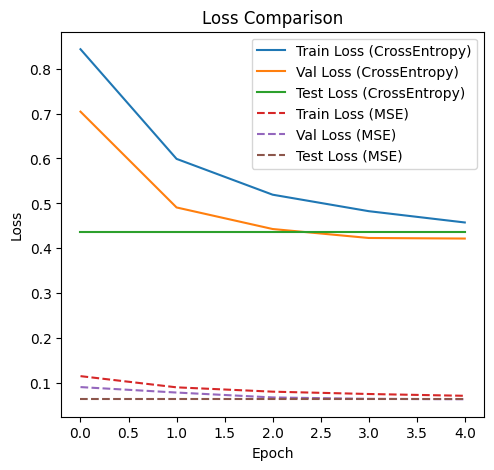

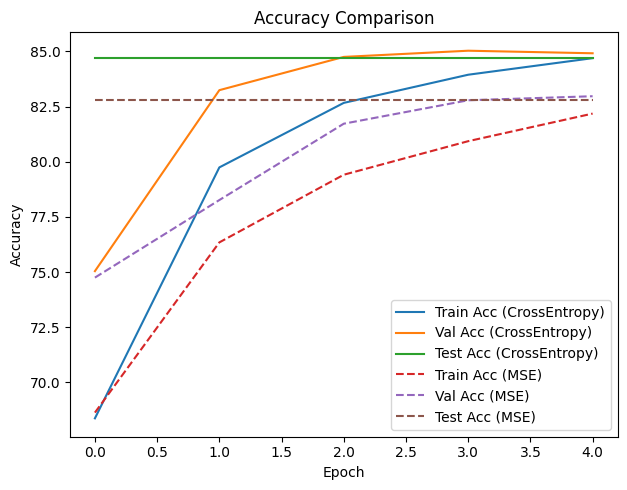

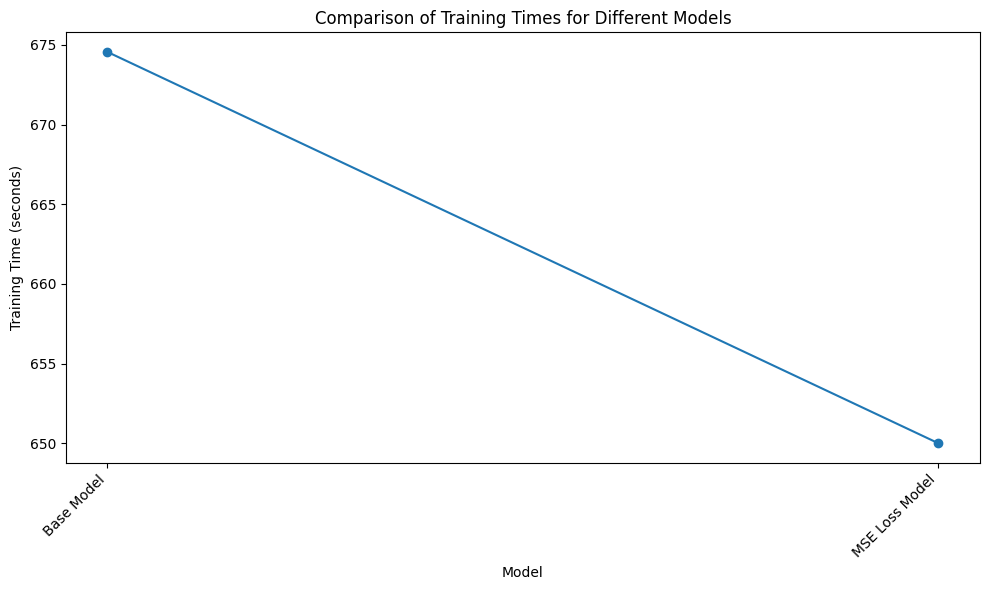

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (CrossEntropy)')
plt.plot(val_losses, label='Val Loss (CrossEntropy)')
plt.plot([test_loss_base] * num_epochs, label='Test Loss (CrossEntropy)')
plt.plot(train_losses_mse, label='Train Loss (MSE)', linestyle='--')
plt.plot(val_losses_mse, label='Val Loss (MSE)', linestyle='--')
plt.plot([test_loss_mse] * num_epochs, label='Test Loss (MSE)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc (CrossEntropy)')
plt.plot(val_accuracies, label='Val Acc (CrossEntropy)')
plt.plot([test_accuracy_base] * num_epochs, label='Test Acc (CrossEntropy)')
plt.plot(train_accuracies_mse, label='Train Acc (MSE)', linestyle='--')
plt.plot(val_accuracies_mse, label='Val Acc (MSE)', linestyle='--')
plt.plot([test_accuracy_mse] * num_epochs, label='Test Acc (MSE)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(model_names, times, marker='o', linestyle='-')
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.title("Comparison of Training Times for Different Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [20]:
# Add learning rate scheduler to the base model
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model with the scheduler
train_losses_scheduler, val_losses_scheduler = [], []
train_accuracies_scheduler, val_accuracies_scheduler = [], []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses_scheduler.append(train_loss)
    train_accuracies_scheduler.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses_scheduler.append(val_loss)
    val_accuracies_scheduler.append(val_accuracy)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
training_time_scheduler = time.time() - start_time
print(f"Training completed in {training_time_scheduler:.2f} seconds.")
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()
test_loss /= len(test_loader)
test_accuracy_scheduler = 100 * correct_test / total_test
print(f"Test Loss with Learning Rate Scheduler: {test_loss:.4f}, Test Accuracy: {test_accuracy_scheduler:.2f}%")

Epoch [1/5], Train Loss: 0.4409, Train Acc: 85.36%, Val Loss: 0.3884, Val Acc: 86.28%
Epoch [2/5], Train Loss: 0.4240, Train Acc: 85.74%, Val Loss: 0.3743, Val Acc: 86.65%
Epoch [3/5], Train Loss: 0.4095, Train Acc: 86.19%, Val Loss: 0.3715, Val Acc: 86.73%
Epoch [4/5], Train Loss: 0.3730, Train Acc: 87.31%, Val Loss: 0.3465, Val Acc: 87.71%
Epoch [5/5], Train Loss: 0.3645, Train Acc: 87.56%, Val Loss: 0.3407, Val Acc: 87.87%
Training completed in 603.10 seconds.
Test Loss with Learning Rate Scheduler: 0.3571, Test Accuracy: 87.63%


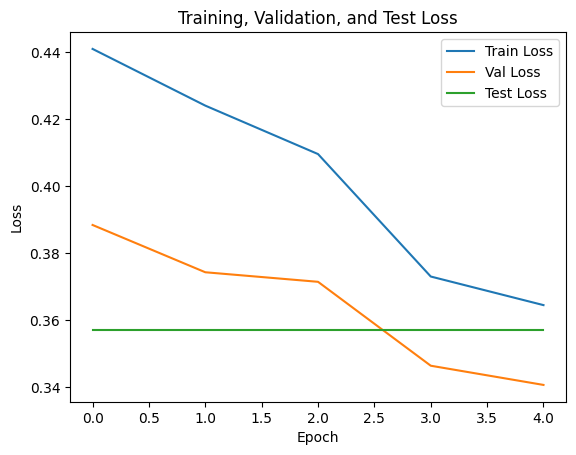

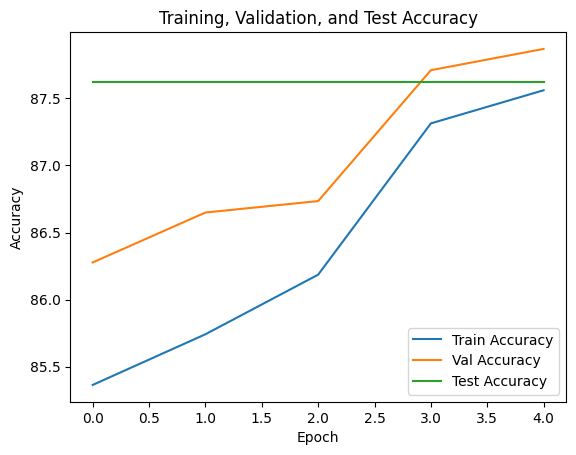

In [21]:
plt.plot(train_losses_scheduler, label='Train Loss')
plt.plot(val_losses_scheduler, label='Val Loss')
plt.plot([test_loss] * num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


plt.plot(train_accuracies_scheduler, label='Train Accuracy')
plt.plot(val_accuracies_scheduler, label='Val Accuracy')
plt.plot([test_accuracy_scheduler] * num_epochs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [22]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

model_bn = CNNWithBN()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)
train_losses_bn, val_losses_bn = [], []
train_accuracies_bn, val_accuracies_bn = [], []
start_time = time.time()
for epoch in range(num_epochs):
    model_bn.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model_bn(inputs)
        loss = loss_function(outputs, labels)

        optimizer_bn.zero_grad()
        loss.backward()
        optimizer_bn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses_bn.append(train_loss)
    train_accuracies_bn.append(train_accuracy)

    model_bn.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model_bn(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses_bn.append(val_loss)
    val_accuracies_bn.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

model_bn.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model_bn(test_inputs)
        test_loss += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()
training_time_bn = time.time() - start_time
print(f"Training completed in {training_time_bn:.2f} seconds.")
test_loss /= len(test_loader)
test_accuracy_bn = 100 * correct_test / total_test
print(f"Test Loss with BatchNorm: {test_loss:.4f}, Test Accuracy: {test_accuracy_bn:.2f}%")

Epoch [1/5], Train Loss: 0.4883, Train Acc: 82.88%, Val Loss: 0.3918, Val Acc: 85.90%
Epoch [2/5], Train Loss: 0.3586, Train Acc: 87.38%, Val Loss: 0.3728, Val Acc: 87.09%
Epoch [3/5], Train Loss: 0.3075, Train Acc: 89.01%, Val Loss: 0.3201, Val Acc: 88.89%
Epoch [4/5], Train Loss: 0.2684, Train Acc: 90.52%, Val Loss: 0.3050, Val Acc: 88.89%
Epoch [5/5], Train Loss: 0.2381, Train Acc: 91.64%, Val Loss: 0.2958, Val Acc: 89.42%
Training completed in 771.54 seconds.
Training completed in 783.33 seconds.
Test Loss with BatchNorm: 0.3049, Test Accuracy: 89.36%


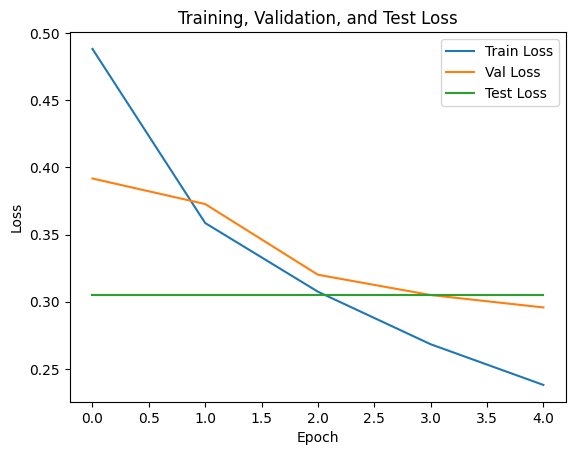

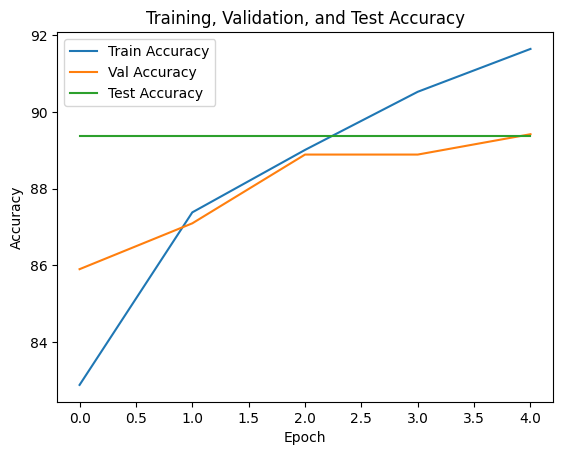

In [23]:
plt.plot(train_losses_bn, label='Train Loss')
plt.plot(val_losses_bn, label='Val Loss')
plt.plot([test_loss] * num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


plt.plot(train_accuracies_bn, label='Train Accuracy')
plt.plot(val_accuracies_bn, label='Val Accuracy')
plt.plot([test_accuracy_bn] * num_epochs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [24]:
train_losses_es, val_losses_es = [], []
train_accuracies_es, val_accuracies_es = [], []
best_val_loss = float('inf')
patience = 3
trigger_times = 0
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses_es.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies_es.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_losses_es.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_es.append(val_accuracy)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
training_time_es = time.time() - start_time
print(f"Training completed in {training_time_es:.2f} seconds.")
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

test_loss /= len(test_loader)
test_accuracy_es = 100 * correct_test / total_test
print(f"Test Loss with Early Stopping: {test_loss:.4f}, Test Accuracy: {test_accuracy_es:.2f}%")

Epoch [1/5], Train Loss: 0.3607, Train Acc: 87.68%, Val Loss: 0.3401, Val Acc: 87.95%
Epoch [2/5], Train Loss: 0.3573, Train Acc: 87.90%, Val Loss: 0.3389, Val Acc: 87.89%
Epoch [3/5], Train Loss: 0.3552, Train Acc: 87.88%, Val Loss: 0.3333, Val Acc: 88.16%
Epoch [4/5], Train Loss: 0.3515, Train Acc: 87.98%, Val Loss: 0.3334, Val Acc: 88.25%
Epoch [5/5], Train Loss: 0.3499, Train Acc: 88.01%, Val Loss: 0.3306, Val Acc: 88.34%
Training completed in 621.56 seconds.
Test Loss with Early Stopping: 0.3462, Test Accuracy: 88.10%


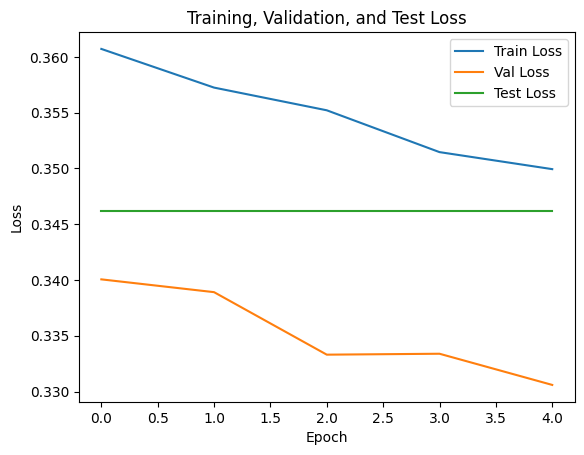

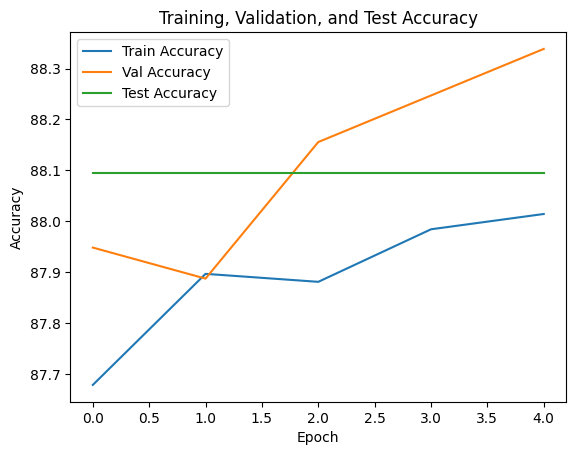

In [25]:
plt.plot(train_losses_es, label='Train Loss')
plt.plot(val_losses_es, label='Val Loss')
plt.plot([test_loss] * num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies_es, label='Train Accuracy')
plt.plot(val_accuracies_es, label='Val Accuracy')
plt.plot([test_accuracy_es] * num_epochs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [26]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
train_dataset_aug = TensorDataset(X_train_tensor, y_train_tensor)
train_dataset_aug.transform = transform
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
train_losses_aug, val_losses_aug = [], []
train_accuracies_aug, val_accuracies_aug = [], []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader_aug:
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader_aug)
    train_accuracy = 100 * correct_train / total_train
    train_losses_aug.append(train_loss)
    train_accuracies_aug.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses_aug.append(val_loss)
    val_accuracies_aug.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
training_time_aug = time.time() - start_time
print(f"Training completed in {training_time_aug:.2f} seconds.")
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_loss += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

test_loss /= len(test_loader)
test_accuracy_aug = 100 * correct_test / total_test
print(f"Test Loss with Data Augmentation: {test_loss:.4f}, Test Accuracy: {test_accuracy_aug:.2f}%")

Epoch [1/5], Train Loss: 0.3489, Train Acc: 88.08%, Val Loss: 0.3312, Val Acc: 88.25%
Epoch [2/5], Train Loss: 0.3472, Train Acc: 88.14%, Val Loss: 0.3324, Val Acc: 88.28%
Epoch [3/5], Train Loss: 0.3450, Train Acc: 88.27%, Val Loss: 0.3282, Val Acc: 88.34%
Epoch [4/5], Train Loss: 0.3431, Train Acc: 88.28%, Val Loss: 0.3330, Val Acc: 88.23%
Epoch [5/5], Train Loss: 0.3408, Train Acc: 88.35%, Val Loss: 0.3294, Val Acc: 88.38%
Training completed in 619.81 seconds.
Test Loss with Data Augmentation: 0.3458, Test Accuracy: 88.03%


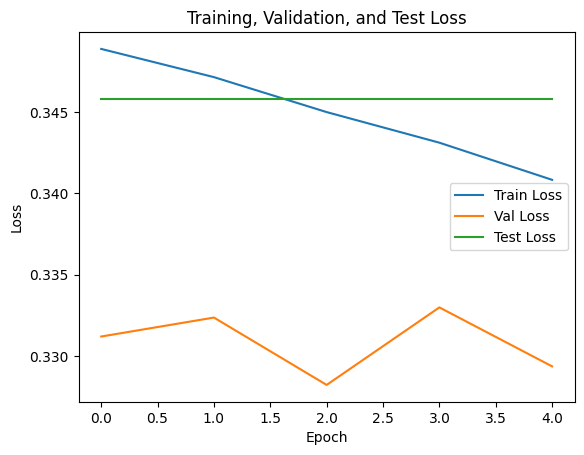

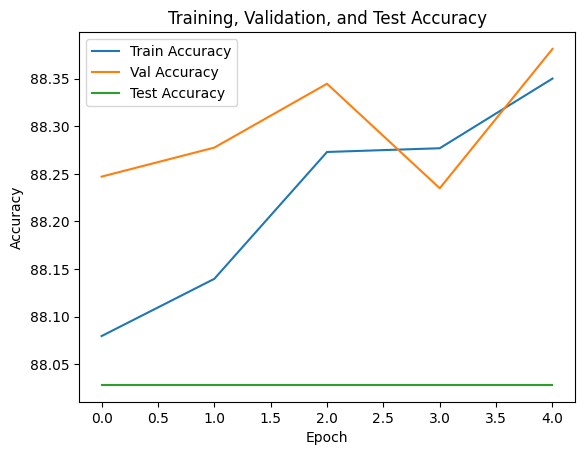

In [27]:
plt.plot(train_losses_aug, label='Train Loss')
plt.plot(val_losses_aug, label='Val Loss')
plt.plot([test_loss] * num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies_aug, label='Train Accuracy')
plt.plot(val_accuracies_aug, label='Val Accuracy')
plt.plot([test_accuracy_aug] * num_epochs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [28]:
training_times = {
     "Model with LR Scheduler": training_time_scheduler,
     "Model with BatchNorm": training_time_bn,
     "Model with Early Stopping": training_time_es,
     "Model with Data Augmentation": training_time_aug,
 }
model_names = list(training_times.keys())
times = list(training_times.values())

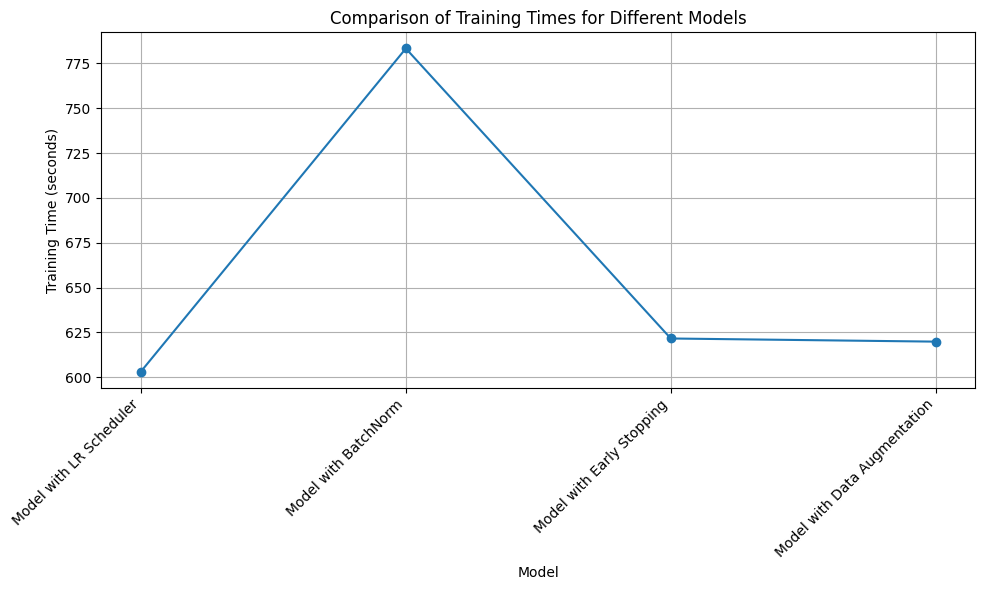

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(model_names, times, marker='o', linestyle='-')
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.title("Comparison of Training Times for Different Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

The best model is: Model with BatchNorm with a test accuracy of 89.36%
Best model weights saved to 'a0_part3_mythrish.pkl'.
Best Model Test Loss: 0.3049, Test Accuracy: 89.36%
Precision: 0.8959, Recall: 0.8936, F1-Score: 0.8945


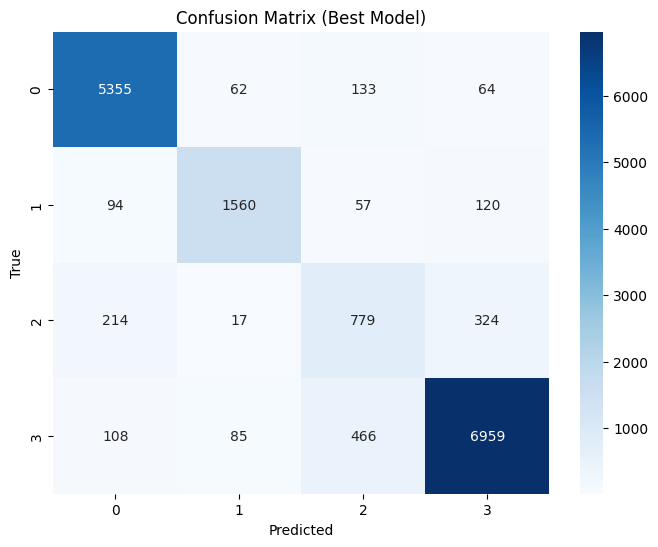

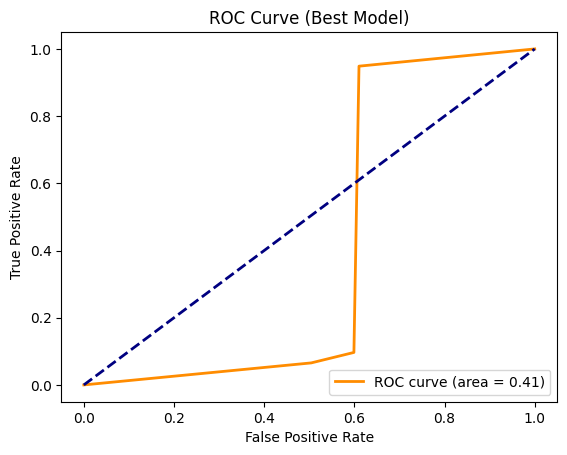

In [30]:
test_accuracies = {
    "Base Model": test_accuracy_base,
    "MSE Loss Model": test_accuracy_mse,
    "Model with LR Scheduler": test_accuracy_scheduler,
    "Model with BatchNorm": test_accuracy_bn,
    "Model with Early Stopping": test_accuracy_es,
    "Model with Data Augmentation": test_accuracy_aug
}

best_model_name = max(test_accuracies, key=test_accuracies.get)
best_model_accuracy = test_accuracies[best_model_name]
print(f"The best model is: {best_model_name} with a test accuracy of {best_model_accuracy:.2f}%")
if best_model_name == "Base Model":
    best_model_weights = model.state_dict()
elif best_model_name == "MSE Loss Model":
    best_model_weights = model_mse.state_dict()
elif best_model_name == "Model with LR Scheduler":
    best_model_weights = model.state_dict()
elif best_model_name == "Model with BatchNorm":
    best_model_weights = model_bn.state_dict()
elif best_model_name == "Model with Early Stopping":
    best_model_weights = model.state_dict()
elif best_model_name == "Model with Data Augmentation":
    best_model_weights = model.state_dict()
with open('a0_part3_mythrish.pkl', 'wb') as f:
    pickle.dump(best_model_weights, f)
print("Best model weights saved to 'a0_part3_mythrish.pkl'.")
with open('a0_part3_mythrish.pkl', 'rb') as f:
    loaded_weights = pickle.load(f)
if best_model_name == "Base Model":
    best_model = CNN()
elif best_model_name == "MSE Loss Model":
    best_model = CNN()
elif best_model_name == "Model with LR Scheduler":
    best_model = CNN()
elif best_model_name == "Model with BatchNorm":
    best_model = CNNWithBN()
elif best_model_name == "Model with Early Stopping":
    best_model = CNN()
elif best_model_name == "Model with Data Augmentation":
    best_model = CNN()
best_model.load_state_dict(loaded_weights)
best_model.eval()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

test_loss_best = 0.0
correct_test_best = 0
total_test_best = 0
all_preds_best = []
all_labels_best = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = best_model(test_inputs)
        test_loss_best += loss_function(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs.data, 1)
        total_test_best += test_labels.size(0)
        correct_test_best += (predicted == test_labels).sum().item()
        all_preds_best.extend(predicted.cpu().numpy())
        all_labels_best.extend(test_labels.cpu().numpy())

test_loss_best /= len(test_loader)
test_accuracy_best = 100 * correct_test_best / total_test_best
print(f"Best Model Test Loss: {test_loss_best:.4f}, Test Accuracy: {test_accuracy_best:.2f}%")
precision_best, recall_best, f1_best, _ = precision_recall_fscore_support(all_labels_best, all_preds_best, average='weighted')
print(f"Precision: {precision_best:.4f}, Recall: {recall_best:.4f}, F1-Score: {f1_best:.4f}")
conf_matrix_best = confusion_matrix(all_labels_best, all_preds_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Model)')
plt.show()
fpr_best, tpr_best, _ = roc_curve(all_labels_best, all_preds_best, pos_label=1)
roc_auc_best = auc(fpr_best, tpr_best)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend(loc="lower right")
plt.show()


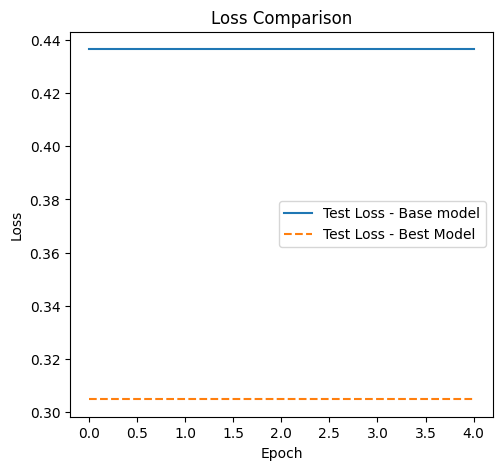

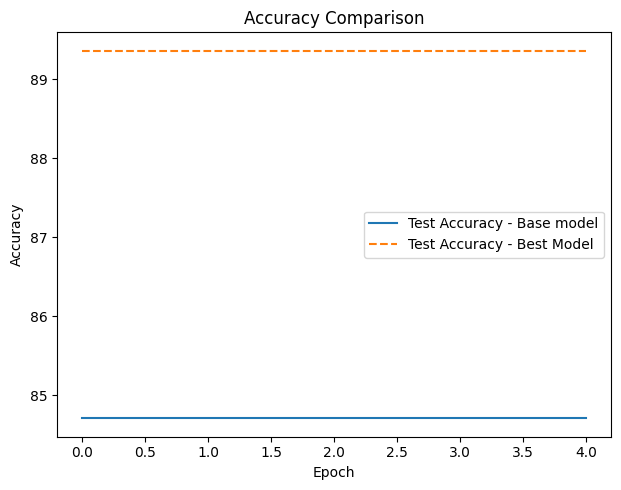

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([test_loss_base] * num_epochs, label='Test Loss - Base model')
plt.plot([test_loss_best] * num_epochs, label='Test Loss - Best Model', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([test_accuracy_base] * num_epochs, label='Test Accuracy - Base model')
plt.plot([test_accuracy_best] * num_epochs, label='Test Accuracy - Best Model', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()
